In [1]:
from collections import defaultdict
from torch_ham import HAM
from torch_ham.synapses import HopfieldSynapse, HopfieldWeight
from torch_ham.neurons import SphericalNormNeuron, SoftmaxNeuron
from torch_ham.optimization import gradient_descent, gradient_descent_step, deq_fixed_point
from torchvision import transforms
from torchvision import datasets
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn.functional as F

In [2]:
# ==== Create model ====
n_image = 28*28 # Number of pixes in image
n_classes = 10  # Number of digit classes
n_hidden = 256  # Number of hidden layers

device = torch.device('cuda')
dtype = torch.float32

neurons = {
    'image': SphericalNormNeuron(shape=(n_image,)),
    'label': SoftmaxNeuron(shape=(n_classes,), beta=0.005)
}

synapses = {
    's0': HopfieldSynapse(
        HopfieldWeight(n_in=n_image, n_hid=n_hidden, device=device, dtype=dtype),
        HopfieldWeight(n_in=n_classes, n_hid=n_hidden, device=device, dtype=dtype),
        beta=7.0
    )
}

connections = {
    's0': ['image', 'label']
}

model = HAM(neurons, synapses, connections)

print(f'#params = {sum(p.numel() for p in model.parameters())}')

#params = 203264


In [3]:
# ==== Load data ====
batch_size = 1000

transform = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST(os.path.expanduser('~/data'), train=True, download=True, transform=transform)
test_set = datasets.MNIST(os.path.expanduser('~/data'), train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

In [4]:
# ==== Setup optimizer ====
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [5]:
# Run training
n_epochs = 4
n_batches = 60_000 // batch_size

for e in range(n_epochs):
    pbar = tqdm(enumerate(train_loader))
    for i, (x, y) in pbar:
        
        x_in = x.view(batch_size, n_image).to(device=device, dtype=dtype).requires_grad_(True)
        y_in = y.to(device=device, dtype=torch.long)

        states = model.init_states(batch_size=batch_size, exclude={'image'}, device=device, dtype=dtype, requires_grad=True)
        states['image'] = x_in.requires_grad_()
        states = deq_fixed_point(model, states, alpha=defaultdict(lambda: 1.0))
        loss = F.cross_entropy(states['label'], y_in, ignore_index=-1)

        optim.zero_grad()
        loss.backward()
        optim.step()
        pbar.set_description(f'loss = {loss.item():2.6f}')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

<IPython.core.display.Javascript object>


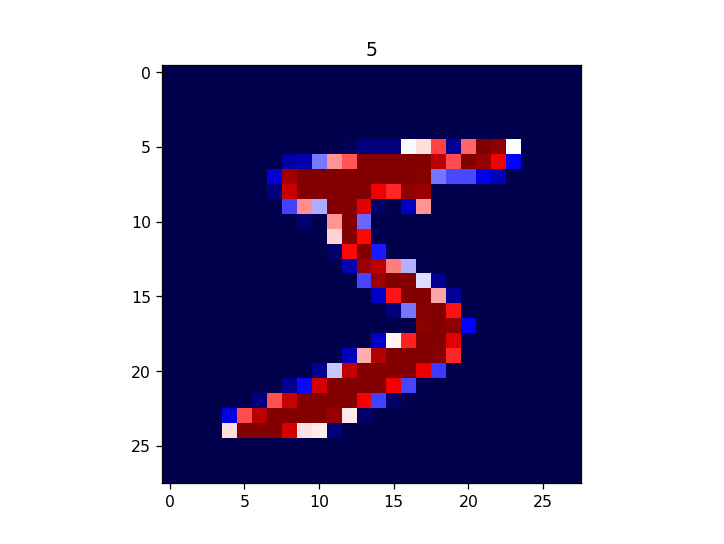

Text(0.5, 1.0, '5')

In [6]:
%matplotlib notebook
x, y = train_set[0]
plt.imshow(x.detach().cpu().numpy().squeeze(), cmap='seismic')
plt.title(f'{y}')

y_true = 5, y_pred = 5


<IPython.core.display.Javascript object>


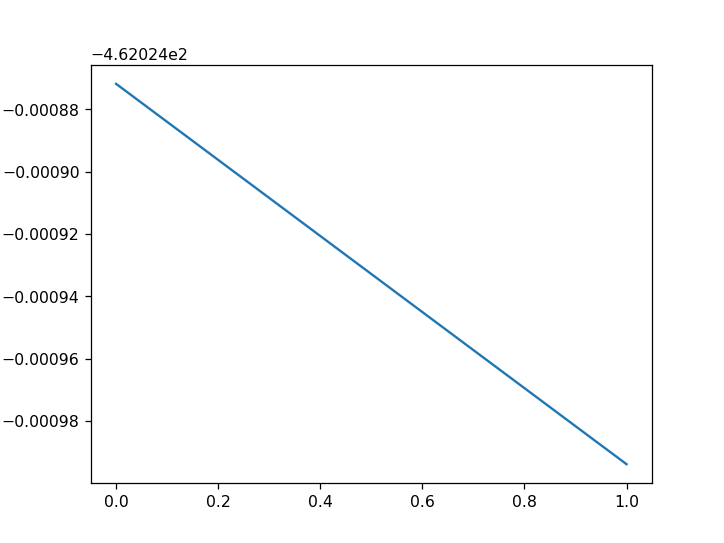

In [7]:
# Label a digit using the trained energy model

# Inititalize states to input image
states = model.init_states(batch_size=1, exclude={'image'}, device=device, dtype=dtype, requires_grad=True)
states['image'] = x.view(1, n_image).to(device=device, dtype=dtype).requires_grad_(True)

# Run standard gradient descent
states = gradient_descent(
    model,
    states,
    max_iter=200,
    alpha=defaultdict(lambda: 1),
    pin={'image'},
    tol=1e-3,
    create_graph=False,
    return_history=True
)

energies = [model.energy(s, model.activations(s)).item() for s in states]
pred = torch.argmax(model.activations(states[-1])['label'])

print(f'y_true = {y}, y_pred = {pred.item()}')
plt.figure()
plt.plot(energies)

<IPython.core.display.Javascript object>


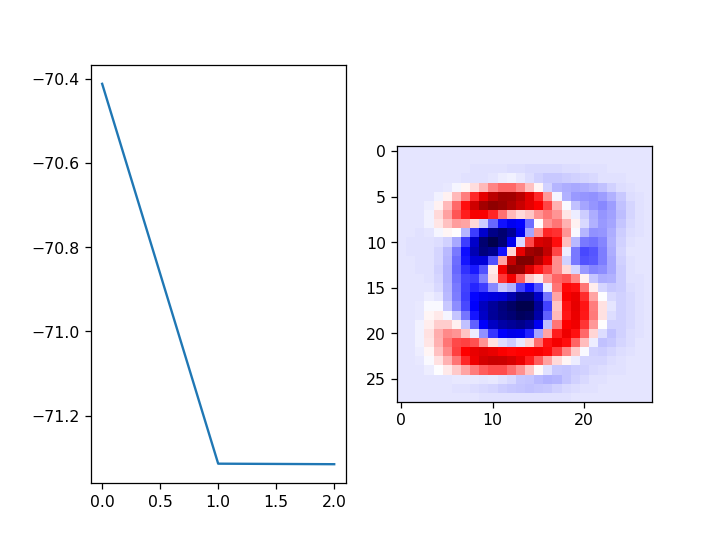

In [8]:
# Generate a digit using the trained energy model
digit = 3

# Inititalize states to a vector of ones and a value of 1000 in the `digit` index
states = model.init_states(batch_size=1, exclude={'label'}, device=device, dtype=dtype, requires_grad=True)
states['label'] = torch.full((1, n_classes,), fill_value=1, device=device, dtype=dtype, requires_grad=False)
states['label'][0,digit] = 1000
states['label'].requires_grad = True

# Run standard gradient descent
states = gradient_descent(
    model,
    states,
    max_iter=200,
    alpha=defaultdict(lambda: 1.0),
    pin={'label'},
    tol=1e-3,
    create_graph=False,
    return_history=True
)

energies = [model.energy(s, model.activations(s)).item() for s in states]
img = model.activations(states[-1])['image']

plt.figure()
plt.subplot(121)
plt.plot(energies)
plt.subplot(122)
plt.imshow(img.detach().cpu().view(1, 28, 28).squeeze().numpy(), cmap='seismic')